# Introduction to Deep Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

# Word2Vec

The aim of this notebook is to implement Word2Vec Continuous Bag of Words (CBOW) as in the [article](https://arxiv.org/pdf/1301.3781.pdf).

## Introduction

__Note__ : word2vec has a lot of technical details which we will skip over to make the understanding a lot easier.

Working scheme:
The idea behind word2vec is quite simple.

1. Take a corpus of texts.
2. Build a training set with _context words_ as features and _center words_ as labels.
3. Train this model (a 3-layers shallow Neural Network) to predict the center word.

The embedding can be extracted out the matrices $W^{[1]}, W^{[2]}$.

<p align="center">
    <img width="655" alt="word2vec" src="https://user-images.githubusercontent.com/49638680/202913353-99ab7ab6-1e69-4264-8601-be30b85a9422.png">
</p>

## Code implementation

Let's start by importing libraries. We are going to use a very basic set of those: just numpy and tensorflow, furthermore we will use matplotlib and sklearn just for visualisation purposes.



In [1]:
# Import libraries

import numpy as np
import tensorflow as tf

from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25,15) # Change the default figure size
%matplotlib inline
%config InlineBackend.figure_format = "retina"

Hence, we define a corpus.

In [2]:
corpus_raw = 'He is the king . The king is royal . She is the royal queen . The king is naked'

# Convert to lower case
corpus_raw = corpus_raw.lower()

Let's now split the corpus into words.

Of course, we could use much more elegant ways to do so, but let's focus on the result, for the sake of clarity.

In [3]:
words = []
for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)
        
words

['he',
 'is',
 'the',
 'king',
 'the',
 'king',
 'is',
 'royal',
 'she',
 'is',
 'the',
 'royal',
 'queen',
 'the',
 'king',
 'is',
 'naked']

### The vocabulary

We are building a vocabulary, hence, we want to remove all the duplicates.

In [4]:
vocab = set(words)
frequency_map = {}

for word in vocab:
    frequency_map[word] = words.count(word)

word2int = {}
int2word = {}
vocab_size = len(vocab) # gives the total number of unique words

print("Size of vocabulary: ", vocab_size)

Size of vocabulary:  8


We now build a basic encoder: each word is identified by its position in the vocab.

In [5]:
for i, word in enumerate(vocab):
    word2int[word] = i
    int2word[i] = word

Now, we split the corpus in sentences, made as a list of words. Again, there are more elegant methods to do so, but we prefer to explicitly compute everything.

In [6]:
# raw sentences is a list of sentences.
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

### Hyperparameters 

Now, it is time to choose some hyperparameter.

In particular, the __context half-size__ $c$, also called _window size_.

Here, we set $c=2$.

Another hyperparameter to set is the _embedding dimension_, that we set as $m=5$.

In [7]:
WINDOW_SIZE = 2
EMBEDDING_DIM = 5

### Training set

Times are mature to build the training set. 

Recall our example,

<p align="center">
    <img width="916" alt="training_set" src="https://user-images.githubusercontent.com/49638680/202918081-12a288b9-97d6-4f1b-ad2a-799b1001a761.png">
</p>

In [8]:
data = []
for sentence in sentences:
    i = WINDOW_SIZE
    center_word = sentence[i]
    context_words = sentence[(i - WINDOW_SIZE):i] + sentence[(i + 1):(i + WINDOW_SIZE + 1)]
    data.append([context_words, center_word])
    i+=1
    if i >= len(sentence):
        print("i is being set to 0")
        i = 0

In [9]:
data # Training set

[[['he', 'is', 'king'], 'the'],
 [['the', 'king', 'royal'], 'is'],
 [['she', 'is', 'royal', 'queen'], 'the'],
 [['the', 'king', 'naked'], 'is']]

#### One-hot encode

Now we need to convert these words into something a model can handle: _i.e._ numerical vectors.

One possible choice is to use one-hot encoding.

In [10]:
# Function to convert numbers to one hot vectors

def to_one_hot(data_point_index, vocab_size):
    tmp = np.zeros(vocab_size)
    tmp[data_point_index] = 1
    return tmp

#### Compose batches

Now, it is left the batch composition, where we get the one-hot encoded vectors and put them together to feed the model.

In [11]:
x_train = [] # input words
y_train = [] # output word

for elem in data:
    y_train.append(to_one_hot(word2int[ elem[1] ], vocab_size))
    x_ohe = np.mean([to_one_hot(word2int[x], vocab_size) for x in elem[0]], axis=0)
    x_train.append(x_ohe)

Just for numerical purpose, we convert such lists into numpy arrays.

In [12]:
x_train = np.array(x_train)
y_train = np.array(y_train)

## The model

We are now ready to define the model.

<p align="center">
    <img width="564" alt="cbow_model" src="https://user-images.githubusercontent.com/49638680/202919935-d5d9c7da-799b-42da-8570-336bbd82249b.png">
</p>

In [13]:
inputs = tf.keras.Input(shape=vocab_size)
emb = tf.keras.layers.Dense(units=EMBEDDING_DIM, activation="relu", name="HiddenRepresentation")(inputs)
outputs = tf.keras.layers.Dense(units=vocab_size, activation="softmax")(emb)

model = tf.keras.Model(inputs=inputs, outputs = outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam")
model.summary()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 HiddenRepresentation (Dense  (None, 5)                45        
 )                                                               
                                                                 
 dense (Dense)               (None, 8)                 48        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


2022-11-21 09:44:38.560447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-21 09:44:38.560582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.fit(x_train, y_train, epochs=2);

Epoch 1/2


2022-11-21 09:44:39.431541: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-21 09:44:39.588766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 266ms/step - loss: 2.0890
Epoch 2/2
1/1 [==============================] - 0s 10ms/step - loss: 2.0867


### Extracting embeddings

In order to extract embeddings we can choose 3 methods:

1. For each word in the vocabulary, the embedding vector is the corresponding $W^{[1]}$ row.
2. For each word in the vocabulary, the embedding vector is the corresponding $W^{[2]}$ column.
3. For each word in the vocabulary, the embedding vector is the average between $W^{[1]}$ row and $W^{[2]}$ column.

In [15]:
W1 = model.layers[1].get_weights()[0]
W2 = model.layers[2].get_weights()[0]
print(f"The W^[1] shape is: {model.layers[1].get_weights()[0].shape}")
print(f"The W^[2] shape is: {model.layers[2].get_weights()[0].shape}")

The W^[1] shape is: (8, 5)
The W^[2] shape is: (5, 8)


In [16]:
embedding_vectors =  (W1 + W2.T)/2

In [17]:
word = "king"
print(f"Embedding vector for the word {word}: {embedding_vectors[word2int[word]]}")

Embedding vector for the word king: [ 0.17812757  0.4852795   0.31124464 -0.21311425 -0.02574617]


### Plotting embeddings

Let's plot the embeddings in two dimensions.

/Users/oscardefelice/miniconda3/envs/dl_lectures/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


king 0.61684555
royal -0.7409974
queen 0.4125304
naked 0.6930266
the 0.8400152
is -0.16858554
he -0.7799107
she 0.9995121


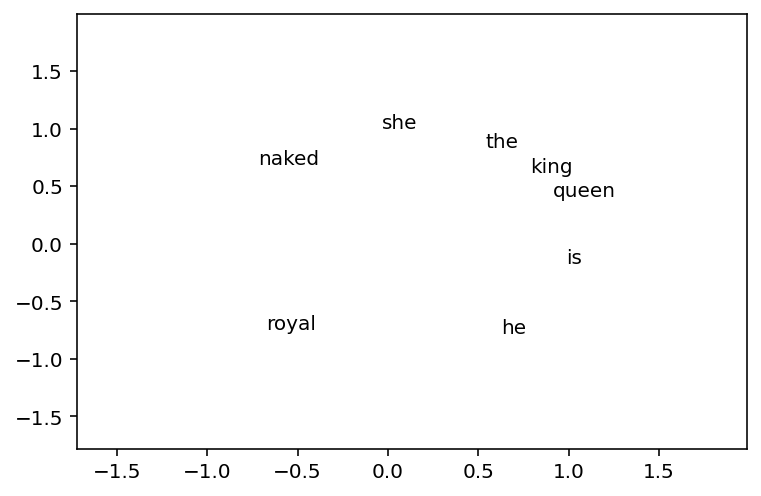

In [18]:
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
np.set_printoptions(suppress=True)

red_emb = tsne.fit_transform(embedding_vectors)

normaliser = Normalizer()
red_emb =  normaliser.fit_transform(red_emb, 'l2')

fig, ax = plt.subplots()

for word in vocab:
    print(word, red_emb[word2int[word]][1])
    ax.annotate(word, (red_emb[word2int[word]][0],red_emb[word2int[word]][1] ))
    ax.set_xlim(min([red_emb[word2int[w]][0] for w in words])-1, max([red_emb[word2int[w]][0] for w in words])+1)
    ax.set_ylim(min([red_emb[word2int[w]][1] for w in words])-1, max([red_emb[word2int[w]][1] for w in words])+1)
plt.show()